<a href="https://colab.research.google.com/github/cdario79/CrossSellingAssicuratvo/blob/main/Cross_Selling_Assicurativo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CARICAMENTO LIBRERIE UTILIZZATE

In [2]:
# Install necessary libraries for handling imbalanced datasets and advanced machine learning models
!pip install imbalanced-learn catboost xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [3]:
# === Data handling and visualization ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# === Statistical tests ===
from scipy.stats import chi2_contingency, mannwhitneyu

# === Scikit-learn: preprocessing, modeling, evaluation, and utilities ===
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    classification_report,
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# === Advanced classifiers ===
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# === Imbalanced data handling ===
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

## CARICAMENTO E COMPRENSIONE DEL DATASET

Il dataset `insurance_cross_sell.csv` contiene informazioni sui clienti con le seguenti variabili:
- `id`: identificativo univoco del cliente
- `Gender`: sesso del cliente
- `Age`: età del cliente
- `Driving_License`: se il cliente possiede la patente di guida (1 = sì, 0 = no)
- `Region_Code`: codice univoco della regione di residenza del cliente
- `Previously_Insured`: se il cliente ha già un veicolo assicurato (1 = sì, 0 = no)
- `Vehicle_Age`: età del veicolo
- `Vehicle_Damage`: se il cliente ha avuto danni in passato al veicolo (1 = sì, 0 = no)
- `Annual_Premium`: importo del premio assicurativo annuale
- `PolicySalesChannel`: canale utilizzato per vendere la polizza (es. email, telefono, di persona)
- `Vintage`: giorni da cui il cliente è assicurato con la compagnia
- `Response`: se il cliente ha accettato l'offerta di cross-sell (1 = sì, 0 = no)

In [4]:
# Define the URL of the dataset
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv'

# Load the dataset directly from the URL into a pandas DataFrame
df = pd.read_csv(url)

In [5]:
# Display the first rows of the DataFrame to get an overview of the data
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


La colonna *id* rappresenta l'identificativo univoco di ogni cliente, questa verrà rimossa prima della creazione del modello in quanto non significativa per la previsione.

In [6]:
# Display the number of rows and columns in the DataFrame
df.shape

(381109, 12)

Ho un buon numero di osservazioni per poter addestrare anche modelli complessi, dovrò fare ulteriori analisi per capire la qualità dei dati prima di proseguire.

In [7]:
# Check for missing values in each column of the DataFrame
df.isnull().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In tutte le colonne del dataset con ci sono valori nulli

In [8]:
# Count the occurrences of each class in the target variable 'Response'
df['Response'].value_counts()

,count
Response,
0,334399
1,46710


La variabile "Response" contiene due classi, e dal conteggio noto subito uno sblilanciamento tra le classe positiva e quella negativa, dovrò trattare questo squilibrio prima di proseguire con la creazione del modello.

In [9]:
# Display summary information about the DataFrame,
# including the number of non-null values and data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [10]:
# Check the number of unique values in columns
df[['Gender', 'Vehicle_Age', 'Vehicle_Damage']].nunique()

,0
Gender,2
Vehicle_Age,3
Vehicle_Damage,2


In [11]:
# Print the unique values for each column
for col in ['Gender', 'Vehicle_Age', 'Vehicle_Damage']:
    print(f"{col}: {df[col].unique()}")

Gender: ['Male' 'Female']
Vehicle_Age: ['> 2 Years' '1-2 Year' '< 1 Year']
Vehicle_Damage: ['Yes' 'No']


*Gender, Vehicle_Age* e *Vehicle_Damage* sono variabili categoriche e sono salvate nel dataset come stringhe, percui dovrò codificarle correttamente prima di utilizzarle nel modello.

In [12]:
# Check the number of unique values in columns
df[['Driving_License', 'Previously_Insured']].nunique()

,0
Driving_License,2
Previously_Insured,2


In [13]:
# Print the unique values for each column
for col in ['Driving_License', 'Previously_Insured']:
    print(f"{col}: {df[col].unique()}")

Driving_License: [1 0]
Previously_Insured: [0 1]


*Driving_License* e *Previously_Insured* sono variabili categoriche pur avendo già valori numerici (1 e 0) quindi è già possibile utilizzarle così come sono nella creazione del modello.

In [14]:
# Check the number of unique values in columns
df[['Region_Code', 'Policy_Sales_Channel']].nunique()

,0
Region_Code,53
Policy_Sales_Channel,155


In [15]:
# Print the unique values for each column
for col in ['Region_Code', 'Policy_Sales_Channel']:
    print(f"{col}: {df[col].unique()}")

Region_Code: [28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.]
Policy_Sales_Channel: [ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  15.
 154.  16.  52. 155.  11. 151. 125.  25.  61.   1.  86.  31. 150.  23.
  60.  21. 121.   3. 139.  12.  29.  55.   7.  47. 127. 153.  78. 158.
  89.  32.   8.  10. 120.  65.   4.  42.  83. 136.  24.  18.  56.  48.
 106.  54.  93. 116.  91.  45.   9. 145. 147.  44. 109.  37. 140. 107.
 128. 131. 114. 118. 159. 119. 105. 135.  62. 138. 129.  88.  92. 111.
 113.  73.  36.  28.  35.  59.  53. 148. 133. 108.  64.  39.  94. 132.
  46.  81. 103.  90.  51.  27. 146.  63.  96.  40.  66. 100.  95. 123.
  98.  75.  69. 130. 134.  49.  97.  38.  17. 110.  80.  71. 117.  58.
  20.  76. 104.  87.  84. 137. 126.  68.  67. 101. 115.  57.  82.  79.
 112.  99.  70.   2.  34.  33.  74. 102

*Region_Code* e *Policy_Sales_Channel* sono entrambe variabili categoriche ma con diversa cardinalità. Avendo molti valori dovrò fare attenzione nella codifica e trovare un metodo efficace per evitare di andare a creare troppe feature nel modello.

In [16]:
# Display summary statistics for selected columns
df[['Age', 'Annual_Premium', 'Vintage' ]].describe()

,Age,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


Noto subito una possibile presenza di outliner in *Annual_Premium*, da valutare l'impatto.

## ANALISI DEL DATASET

In [17]:
# Clone original dataset
df1 = df.copy()

### ANALISI DELLA VARIABILE TARGET *RESPONSE*

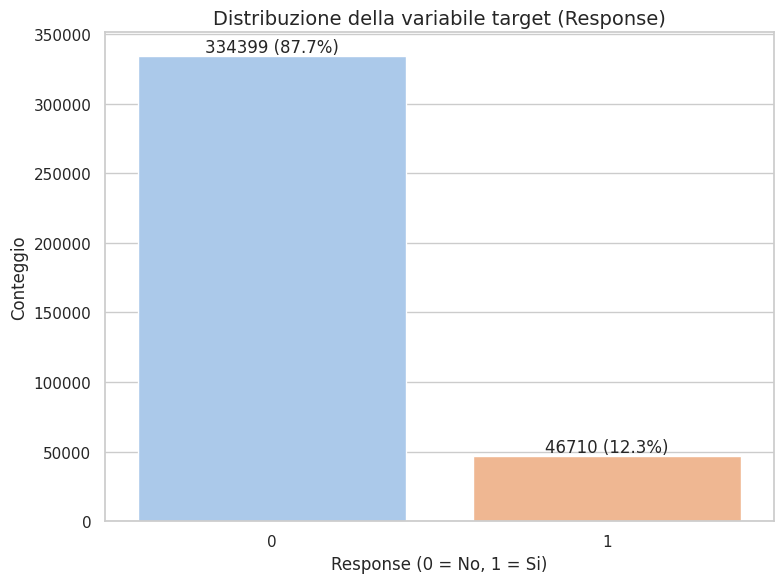

In [18]:
# Set the general style of seaborn plots to 'whitegrid' for a clean background with gridlines
sns.set(style="whitegrid")

# Create a new figure with a specified size (8 inches wide by 6 inches tall)
plt.figure(figsize=(8, 6))

# Create a bar plot showing the count of each class in the 'Response' column
# 'hue=Response' means the bars are also color-coded by the same variable
# 'palette="pastel"' applies soft colors, and 'legend=False' removes the automatic legend
ax = sns.countplot(x='Response', hue='Response', data=df, palette='pastel', legend=False)

# Set the title of the plot with a custom font size
plt.title('Distribuzione della variabile target (Response)', fontsize=14)

# Calculate the total number of records to compute percentages
total = len(df1)

# Loop over each bar in the plot to annotate with exact count and percentage
for p in ax.patches:
    count = int(p.get_height())  # Get the height of the bar (i.e., count of samples)
    percentage = 100 * count / total  # Calculate the percentage of total samples
    # Place the annotation slightly above the bar, centered horizontally
    ax.annotate(f'{count} ({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),  # X, Y position
                ha='center', va='bottom', fontsize=12)  # Horizontal and vertical alignment, font size

# Label the X-axis to indicate it refers to the 'Response' values (0 = No, 1 = Yes)
plt.xlabel('Response (0 = No, 1 = Si)')

# Label the Y-axis to indicate it shows the number of records
plt.ylabel('Conteggio')

# Adjust layout to prevent clipping of labels or titles
plt.tight_layout()

# Display the plot in the output
plt.show()

Visualizzando la variabile *Response* nel grafico e calcolando le percentuali per ogni classe si conferma lo sbilanciamento e la necessità di trattarlo in modo opportuno.

### ANALISI DELLA VARIABILE *GENDER*

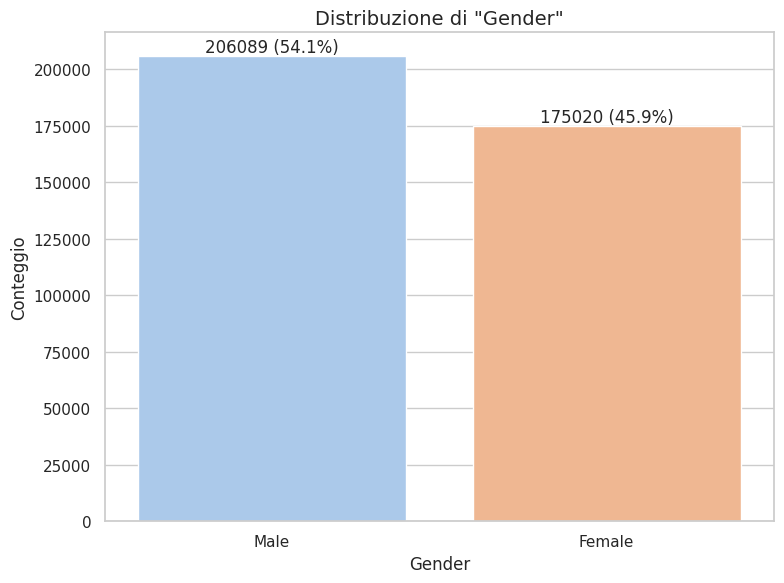

In [19]:
# Set seaborn theme
sns.set(style="whitegrid")

# Create a new figure with defined size
plt.figure(figsize=(8, 6))

# Updated: add 'hue="Gender"' to avoid FutureWarning when using palette
ax = sns.countplot(x='Gender', hue='Gender', data=df, palette='pastel', legend=False)

# Add plot title
plt.title('Distribuzione di "Gender"', fontsize=14)

# Total number of samples
total = len(df1)

# Annotate each bar with count and percentage
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{count} ({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

# Axis labels
plt.xlabel('Gender')
plt.ylabel('Conteggio')

# Layout adjustment
plt.tight_layout()

# Display the plot
plt.show()

Nel campione sono presenti più uomini che donne, ma posso dire che entrambi i generi sono ben rappresentati.

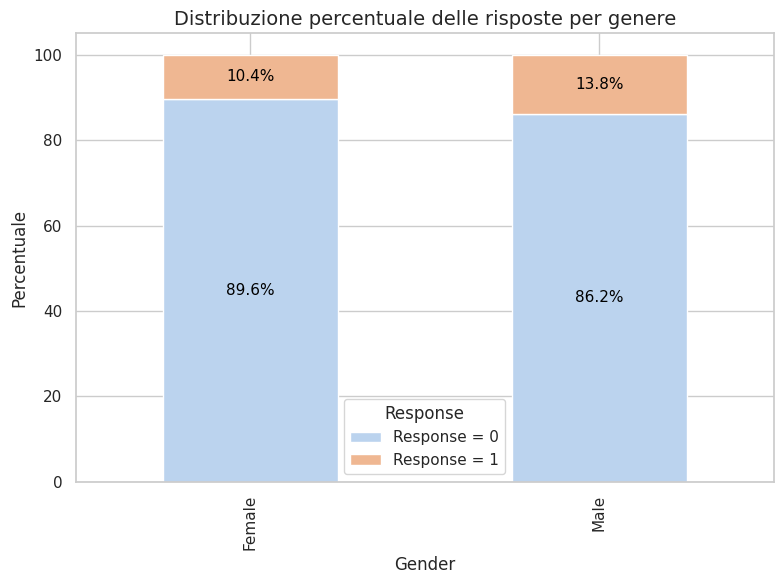

In [20]:
# Set Seaborn style for the plot
sns.set(style="whitegrid")

# Compute contingency table (percentages by gender)
contingency_gender = df1.groupby('Gender')['Response'].value_counts(normalize=True).unstack().fillna(0) * 100
contingency_gender = contingency_gender.round(1)

# Rename columns for clarity
contingency_gender.columns = ['Response = 0', 'Response = 1']

# Reorder columns explicitly
contingency_gender = contingency_gender[['Response = 0', 'Response = 1']]

# Crea il grafico a barre impilate
ax = contingency_gender.plot(kind='bar', stacked=True, color=['#BBD3EE', '#EFB792'], figsize=(8, 6))

# Annotate bars with percentage labels
for i, (index, row) in enumerate(contingency_gender.iterrows()):
    y_offset = 0
    for j, value in enumerate(row):
        ax.annotate(f'{value:.1f}%',
                    (i, y_offset + value / 2),
                    ha='center', va='center', fontsize=11, color='black')
        y_offset += value

# Set title and axis labels
plt.title('Distribuzione percentuale delle risposte per genere', fontsize=14)
plt.xlabel('Gender')
plt.ylabel('Percentuale')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

Nel nostro campione i clienti di sesso maschile presentano un tasso di adesione maggiore rispetto alle clienti di sesso femminile.

### ANALISI DELLA VARIABILE *AGE*

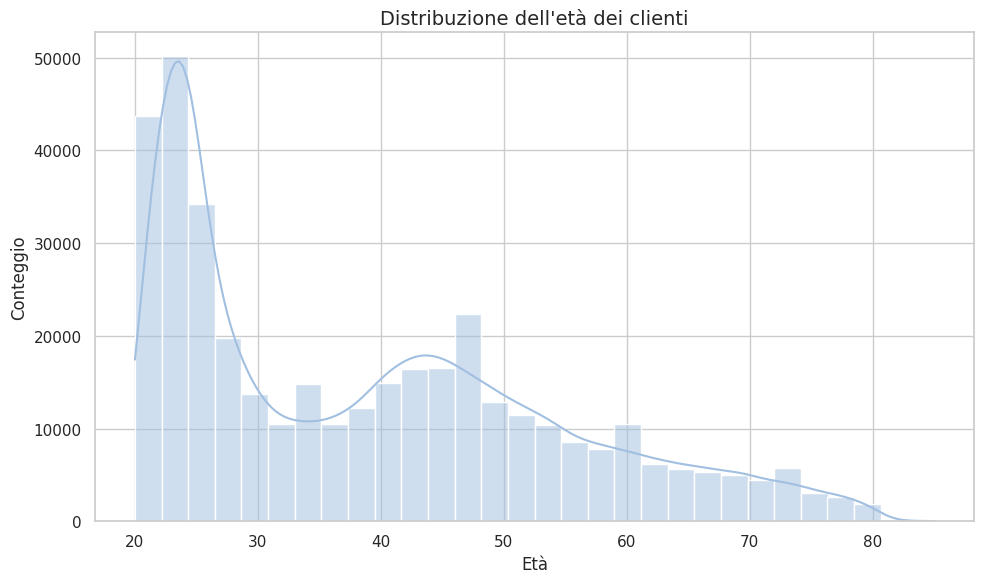

In [21]:
# Set seaborn style for consistency
sns.set(style="whitegrid")

# Create a new figure with custom size
plt.figure(figsize=(10, 6))

# Create a histogram with a KDE (kernel density estimate) overlay
# This shows both the distribution and its smooth trend
sns.histplot(df1['Age'], bins=30, kde=True, color='#a1bfe0', edgecolor='white')

# Set a descriptive title
plt.title('Distribuzione dell\'età dei clienti', fontsize=14)

# Label axes
plt.xlabel('Età')
plt.ylabel('Conteggio')

# Improve layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

La maggior parte dei clienti ha un'età tra i 20 e i 30 anni, la distribuzione è asimmetrica verso destra.

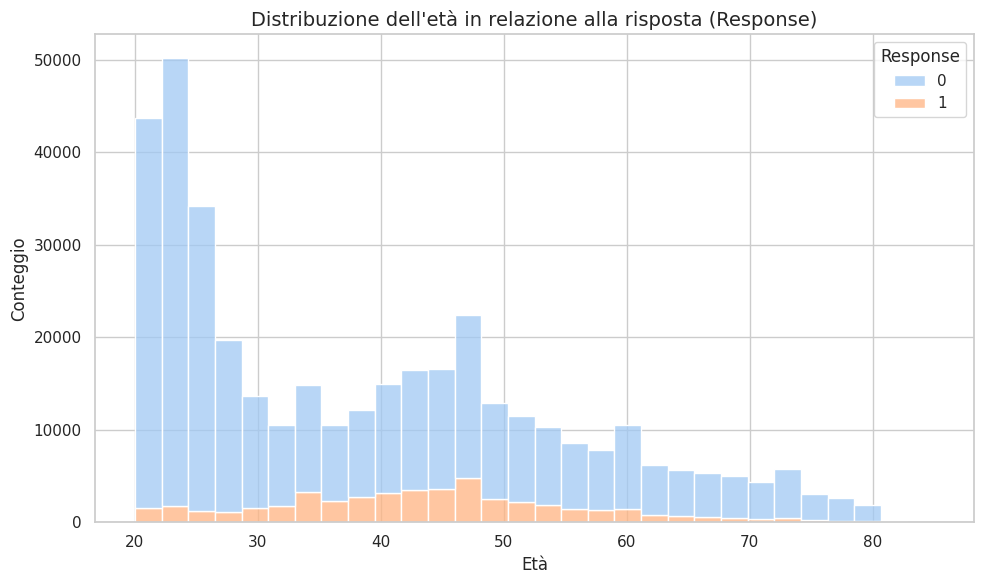

In [22]:
# Set seaborn style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Histogram of Age, colored by Response (0 = no, 1 = yes)
sns.histplot(data=df1, x='Age', hue='Response', bins=30, kde=False, palette='pastel', multiple='stack')

# Title
plt.title('Distribuzione dell\'età in relazione alla risposta (Response)', fontsize=14)

# Axis labels
plt.xlabel('Età')
plt.ylabel('Conteggio')

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()

- I clienti tra i 20 e i 30 anni sono di più ma hanno una percentuale di accettazione bassa.
- I clienti tra i 30 e i 60 anni sembrano avere la migliore percentuale di accettazione.
- I clienti oltre i 60 anni sono pochi e la percentuale di accettazione è minima rispetto alle altre fasce di età.

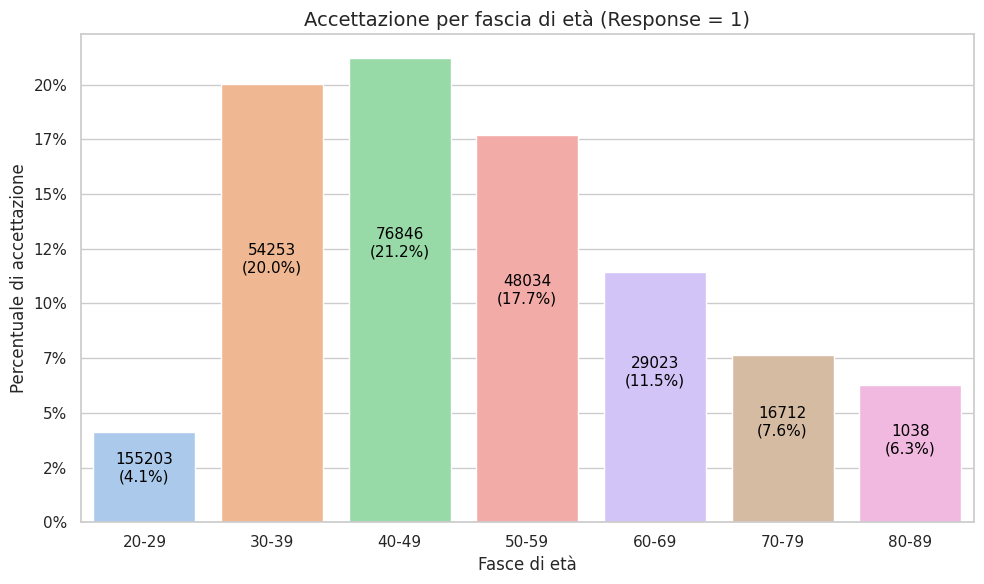

In [23]:
# Set seaborn theme for consistent visuals
sns.set(style="whitegrid")

# Create age bins by decade
df1['Age_bin'] = pd.cut(df1['Age'], bins=[19, 29, 39, 49, 59, 69, 79, 89],
                       labels=['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89'])

# Group by age bin to compute total customers and number of accepted responses
age_grouped = df1.groupby('Age_bin', observed=True).agg(
    total=('Response', 'count'),
    accepted=('Response', 'sum')
).reset_index()

# Calculate acceptance rate for each age group
age_grouped['accept_rate'] = age_grouped['accepted'] / age_grouped['total']

# Create figure with custom size
plt.figure(figsize=(10, 6))

# Create barplot showing acceptance rate by age group
# Each bar represents the proportion of customers in that age range who accepted the offer
ax = sns.barplot(data=age_grouped, x='Age_bin', y='accept_rate',
                 hue='Age_bin', palette='pastel', legend=False)

# Add title and axis labels
plt.title('Accettazione per fascia di età (Response = 1)', fontsize=14)
plt.xlabel('Fasce di età')
plt.ylabel('Percentuale di accettazione')

# Format y-axis as percentages
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y*100)}%'))

# Annotate each bar with the absolute count and percentage inside the bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    total = age_grouped.loc[i, 'total']
    rate = age_grouped.loc[i, 'accept_rate']
    ax.annotate(f'{total}\n({rate:.1%})',
                (bar.get_x() + bar.get_width() / 2., height * 0.6),  # place inside the bar
                ha='center', va='center', fontsize=11, color='black')

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the final plot
plt.show()

Il grafico serve per evidenziare il comportamento dei clienti in ogni fascia di età. Per approfondire se tali differenze sono statisticamente rilevanti costruisco una tabella di contingenza ed eseguo un test del chi-quadro di indipendenza.

In [24]:
# Create the contingency table: rows = Age_bin, columns = Response (0 = no, 1 = yes)
contingency_table = pd.crosstab(df1['Age_bin'], df1['Response'])

# Display the contingency table to observe the distribution of responses across age groups
print("Contingency Table:")
print(contingency_table)

# Apply the chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results of the test
print("\nChi-squared statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p_value, " (valore approssimato)")

Contingency Table:
Response       0      1
Age_bin                
20-29     148829   6374
30-39      43397  10856
40-49      60527  16319
50-59      39537   8497
60-69      25698   3325
70-79      15438   1274
80-89        973     65

Chi-squared statistic: 20083.544178396394
Degrees of freedom: 6
P-value: 0.0  (valore approssimato)


Il test del chi-quadro conferma la presenza di una relazione statisticamente significativa tra le fasce di età e propensione ad accettare l'offerta.

Siccome non ho ancora definito che tipo di modello usare, e considerando che per alcuni modelli potrebbe essere utile mantenere la variabile *Age* in formato continuo, decido di eseguire il **Test di Mann-Whitney U**

(Fonte: [Technology Networks](https://www.technologynetworks.com/informatics/articles/mann-whitney-u-test-assumptions-and-example-363425))

Questo test non parametrico permette di confrontare la distribuzione dell'età nei due gruppi (Response=0 e Response=1) senza fare assunzioni di normalità, inoltre non è influenzato dall'assimmetria della distribuzione e dallo sbilanciamento delle classi.

In [25]:
# Split the Age variable into two groups based on Response
age_accepted = df1[df1['Response'] == 1]['Age']
age_not_accepted = df1[df1['Response'] == 0]['Age']

# Apply the Mann-Whitney U test (non-parametric test for continuous distributions)
statistic, p_value = mannwhitneyu(age_accepted, age_not_accepted, alternative='two-sided')

# Format the p-value in scientific notation
formatted_p = f"{p_value:.6e}"

# Print the results
print("Mann-Whitney U statistic:", statistic)
print("P-value:", formatted_p, '(valore approssimato)')

Mann-Whitney U statistic: 9793606119.5
P-value: 0.000000e+00 (valore approssimato)


Il test di Mann-Whitney U evidenzia un differenza statisticamente significativa anche per la variabile *Age* continua, percui decido di mantenere nel dataset sia la variabile continua che quella divisa in classi *Age_bin*.

### ANALISI DELLA VARIABILE *DRIVING_LICENSE*

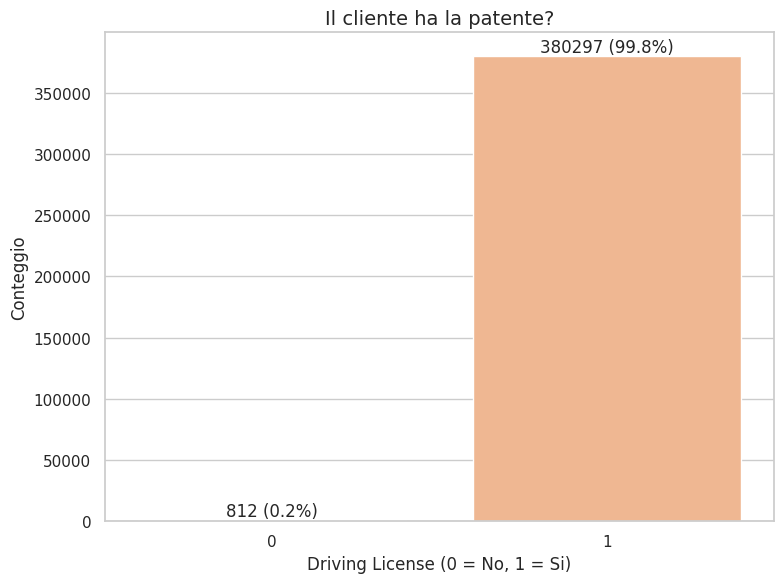

In [26]:
# Set the seaborn style for consistent visuals
sns.set(style="whitegrid")

# Create a new figure of size 8x6 inches
plt.figure(figsize=(8, 6))

# Use countplot to visualize how many customers have a driving license
# Add hue='Driving_License' to avoid future warnings and enable color palette
ax = sns.countplot(x='Driving_License', hue='Driving_License', data=df1, palette='pastel', legend=False)

# Set a descriptive title for the plot
plt.title('Il cliente ha la patente?', fontsize=14)

# Total number of records in the dataset
total = len(df1)

# Loop through the bars to annotate count and percentage on top of each bar
for p in ax.patches:
    count = int(p.get_height())              # Get the bar height (count of records)
    percentage = 100 * count / total         # Calculate the percentage
    ax.annotate(f'{count} ({percentage:.1f}%)',   # Format count and percentage
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Bar center position
                ha='center', va='bottom', fontsize=12)  # Align text

# Label the axes
plt.xlabel('Driving License (0 = No, 1 = Si)')
plt.ylabel('Conteggio')

# Optimize the layout to avoid clipping
plt.tight_layout()

# Display the final plot
plt.show()

La variabile *Driving_License* ha la maggioranza dei valori nella classe 1 (clienti con patente) determinando una distribuzione estremamente sbilanciata. Questa variabile non apporta alcuna informazione utile e pertando decidco di non includerla nella fase di modellazione.

### ANALISI DELLA VARIABILE *REGION_CODE*

In [27]:
df1['Region_Code'] = df1['Region_Code'].astype(int)

# Calcola frequenze assolute e percentuali
channel_freq = df1['Region_Code'].value_counts()
channel_perc = (channel_freq / len(df1) * 100).round(5)

# Crea il DataFrame
channel_summary = pd.DataFrame({
    'Region_Code': channel_freq.index,
    'Count': channel_freq.values,
    'Percentage': channel_perc.values
})

# Ordina per frequenza discendente
channel_summary = channel_summary.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Mostra la tabella
with pd.option_context('display.max_rows', None):
    display(channel_summary)

,Region_Code,Count,Percentage
0,28,106415,27.92246
1,8,33877,8.88906
2,46,19749,5.18198
3,41,18263,4.79207
4,15,13308,3.49191
5,30,12191,3.19882
6,29,11065,2.90337
7,50,10243,2.68768
8,3,9251,2.42739
9,11,9232,2.42240


In [28]:
# Create the contingency table: rows = Region_Code, columns = Response values
contingency_table = pd.crosstab(df1['Region_Code'], df1['Response'])

# Perform the chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the test results
print("Chi-squared Test Results for Region_Code vs Response")
print("-----------------------------------------------------")
print("Chi-squared statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", f"{p_value:.6f}", '(valore approssimato)')

Chi-squared Test Results for Region_Code vs Response
-----------------------------------------------------
Chi-squared statistic: 7267.842468803051
Degrees of freedom: 52
P-value: 0.000000 (valore approssimato)


A seguito del test del chi-quadro che ha confermato una relazione statisticamente rilevante tra *Region_Code* e *Response* vado a creare una variabile *response_behavior* utile per ridurre la dimensionalità mantenendo l'informazione predittiva.

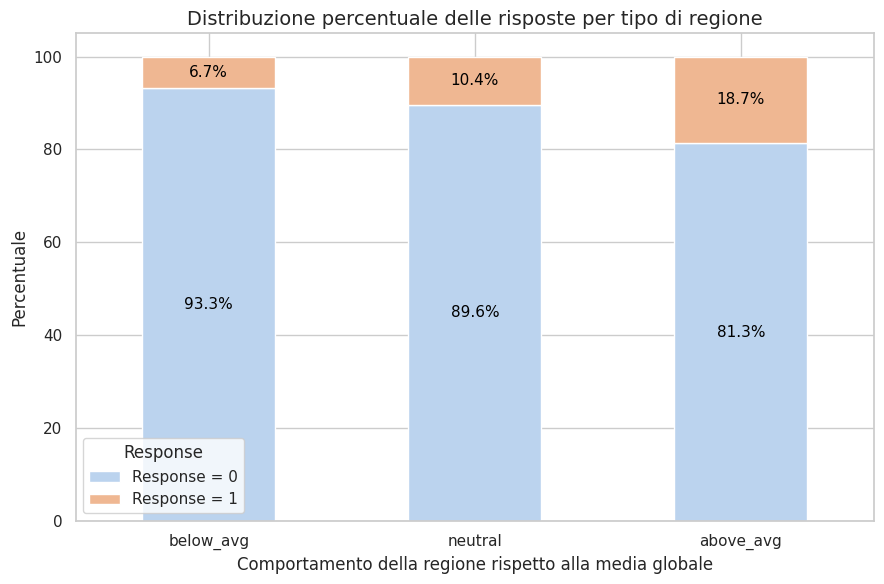

In [29]:
# Calculate acceptance rate for each Region_Code
region_response = df1.groupby('Region_Code')['Response'].agg(['count', 'sum'])
region_response['Acceptance Rate'] = region_response['sum'] / region_response['count']
global_rate = df1['Response'].mean()
region_response['Delta from Global Avg'] = region_response['Acceptance Rate'] - global_rate

# Map region behavior classification back to the main dataframe
def label_response_region(delta, threshold=0.05):
    if delta > threshold:
        return 'above_avg'
    elif delta < -threshold:
        return 'below_avg'
    else:
        return 'neutral'

region_response = region_response.reset_index()
region_response['response_behavior'] = region_response['Delta from Global Avg'].apply(label_response_region)

# Map region behavior classification back to the main dataframe
region_behavior_map = region_response.set_index('Region_Code')['response_behavior'].to_dict()
df1['response_behavior'] = df1['Region_Code'].map(region_behavior_map)

# Create a contingency table for plotting
contingency_behavior = df1.groupby('response_behavior')['Response'].value_counts(normalize=True).unstack().fillna(0) * 100
contingency_behavior = contingency_behavior.round(1)
contingency_behavior.columns = ['Response = 0', 'Response = 1']
contingency_behavior = contingency_behavior.loc[['below_avg', 'neutral', 'above_avg']]  # Ordine visivo

# Plot the stacked bar chart
sns.set(style="whitegrid")
ax = contingency_behavior.plot(kind='bar', stacked=True, color=['#BBD3EE', '#EFB792'], figsize=(9, 6))

# Add percentage annotations to each segment
for i, (index, row) in enumerate(contingency_behavior.iterrows()):
    y_offset = 0
    for j, value in enumerate(row):
        ax.annotate(f'{value:.1f}%',
                    (i, y_offset + value / 2),
                    ha='center', va='center', fontsize=11, color='black')
        y_offset += value

# Set plot titles and layout
plt.title('Distribuzione percentuale delle risposte per tipo di regione', fontsize=14)
plt.xlabel('Comportamento della regione rispetto alla media globale')
plt.ylabel('Percentuale')
plt.xticks(rotation=0)
plt.legend(title='Response')
plt.tight_layout()
plt.show()

Tra le diverse tipologie di regioni è presenta una notevole differenza tra i tassi di accettazione, questa differenza supporta l'utlizzo di questa variabile derivata per il modello predittivo.

### ANALISI DELLA VARIABILE *PREVIOUSLY_INSURED*

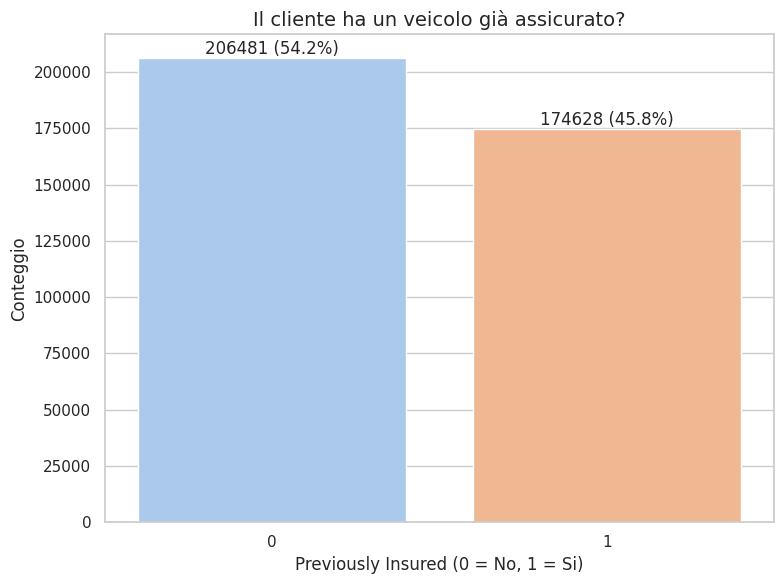

In [30]:
# Set the seaborn theme for consistent styling
sns.set(style="whitegrid")

# Create a new figure for the plot with specified size
plt.figure(figsize=(8, 6))

# Create a countplot to visualize how many customers are previously insured
# Use hue='Previously_Insured' to apply colors and avoid deprecation warning
ax = sns.countplot(x='Previously_Insured', hue='Previously_Insured', data=df1, palette='pastel', legend=False)

# Set the title of the plot
plt.title('Il cliente ha un veicolo già assicurato?', fontsize=14)

# Total number of rows in the dataset
total = len(df1)

# Annotate each bar with the exact count and percentage
for p in ax.patches:
    count = int(p.get_height())               # Height = number of customers
    percentage = 100 * count / total          # Calculate relative percentage
    ax.annotate(f'{count} ({percentage:.1f}%)',   # Annotated label
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position label above the bar
                ha='center', va='bottom', fontsize=12)

# Add axis labels for clarity
plt.xlabel('Previously Insured (0 = No, 1 = Si)')
plt.ylabel('Conteggio')

# Optimize the layout
plt.tight_layout()

# Display the bar chart
plt.show()

La variabile *Previously_Insured* è ben bilanciata tra le due classi e la rende adatta all'inclusione nel modello predittivo.

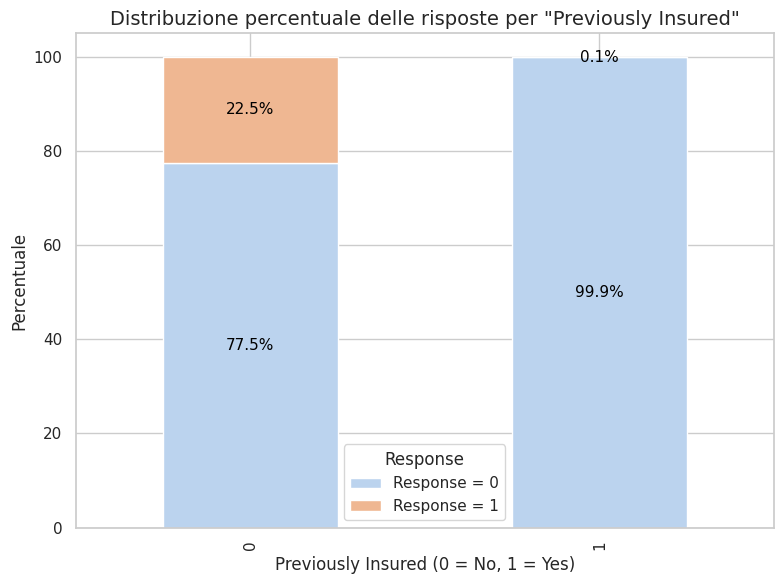

In [31]:
# Set Seaborn style
sns.set(style="whitegrid")

# Compute percentage contingency table for Previously_Insured
contingency_insured = df1.groupby('Previously_Insured')['Response'].value_counts(normalize=True).unstack().fillna(0) * 100
contingency_insured = contingency_insured.round(1)

# Rename columns for clarity
contingency_insured.columns = ['Response = 0', 'Response = 1']

# Optional: reorder columns
contingency_insured = contingency_insured[['Response = 0', 'Response = 1']]

# Plot the stacked bar chart
ax = contingency_insured.plot(kind='bar', stacked=True, color=['#BBD3EE', '#EFB792'], figsize=(8, 6))

# Annotate each bar segment with percentage label
for i, (index, row) in enumerate(contingency_insured.iterrows()):
    y_offset = 0
    for j, value in enumerate(row):
        ax.annotate(f'{value:.1f}%',
                    (i, y_offset + value / 2),
                    ha='center', va='center', fontsize=11, color='black')
        y_offset += value

# Final touches
plt.title('Distribuzione percentuale delle risposte per "Previously Insured"', fontsize=14)
plt.xlabel('Previously Insured (0 = No, 1 = Yes)')
plt.ylabel('Percentuale')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

La variabile *Previously_Insured* presenta una netta differenza sulla percentuale di accettazione dell'offerta tra chi ha già un veicolo assicurato e chi no. Chi non è ancora assicurato ha una maggiore propensione ad accettare l'offerta.

In [32]:
# Create a contingency table: rows = Previously_Insured, columns = Response
contingency_table = pd.crosstab(df1['Previously_Insured'], df1['Response'])

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

# Apply the chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Format the p-value
formatted_p = f"{p_value:.6e}"

# Display the results
print("\nChi-squared statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", formatted_p, '(valore approssimato)')

Contingency Table:
Response                 0      1
Previously_Insured               
0                   159929  46552
1                   174470    158

Chi-squared statistic: 44357.96472219977
Degrees of freedom: 1
P-value: 0.000000e+00 (valore approssimato)


Eseguendo anche il test del chi-quadro ottengo che la relazione tra *Previously_Insured* e *Response* è statististicamente rilevante.

### ANALISI DELLA VARIABILE *VEHICLE_AGE*

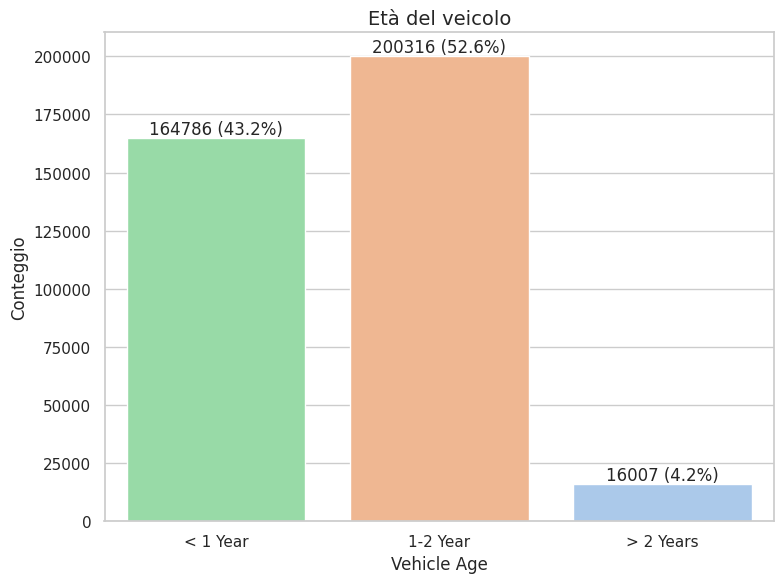

In [33]:
# Set a clean style for seaborn plots
sns.set(style="whitegrid")

# Define the order for vehicle age categories (to preserve logical sequence)
vehicle_age_order = ['< 1 Year', '1-2 Year', '> 2 Years']

# Create a new figure with defined size
plt.figure(figsize=(8, 6))

# Create a countplot for 'Vehicle_Age', ordered by the defined category order
# Add hue='Vehicle_Age' to apply the pastel palette and prevent future warnings
ax = sns.countplot(x='Vehicle_Age', hue='Vehicle_Age', data=df1,
                   palette='pastel', legend=False, order=vehicle_age_order)

# Set a descriptive title
plt.title('Età del veicolo', fontsize=14)

# Total number of entries in the dataset
total = len(df1)

# Annotate each bar with count and percentage
for p in ax.patches:
    count = int(p.get_height())               # Bar height = number of entries
    percentage = 100 * count / total          # Calculate relative percentage
    ax.annotate(f'{count} ({percentage:.1f}%)',   # Format the label
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position label
                ha='center', va='bottom', fontsize=12)  # Alignment and font size

# Label the X and Y axes
plt.xlabel('Vehicle Age')
plt.ylabel('Conteggio')

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

Più del 95% dei clienti ha veicoli con meno di due anni, percui vediamo come varia la risposta in base all'età del veicolo.

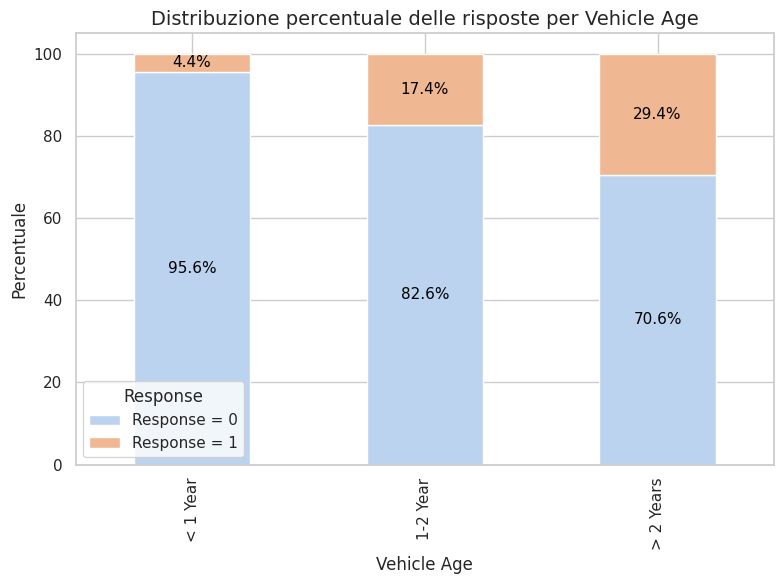

In [34]:
# Set Seaborn style
sns.set(style="whitegrid")

# Compute normalized contingency table (percentages per Vehicle_Age)
contingency_vehicle_age = df1.groupby('Vehicle_Age')['Response'].value_counts(normalize=True).unstack().fillna(0) * 100
contingency_vehicle_age = contingency_vehicle_age.round(1)

# Rename columns for clarity
contingency_vehicle_age.columns = ['Response = 0', 'Response = 1']

# Reorder categories explicitly
vehicle_age_order = ['< 1 Year', '1-2 Year', '> 2 Years']
contingency_vehicle_age = contingency_vehicle_age.reindex(vehicle_age_order)

# Create stacked bar plot
ax = contingency_vehicle_age.plot(kind='bar', stacked=True,
                                  color=['#BBD3EE', '#EFB792'],
                                  figsize=(8, 6))

# Annotate each bar segment with the percentage
for i, (index, row) in enumerate(contingency_vehicle_age.iterrows()):
    y_offset = 0
    for j, value in enumerate(row):
        ax.annotate(f'{value:.1f}%',
                    (i, y_offset + value / 2),
                    ha='center', va='center', fontsize=11, color='black')
        y_offset += value

# Final layout
plt.title('Distribuzione percentuale delle risposte per Vehicle Age', fontsize=14)
plt.xlabel('Vehicle Age')
plt.ylabel('Percentuale')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

In [35]:
# Create the contingency table
contingency_table = pd.crosstab(df1['Vehicle_Age'], df1['Response'])

# Run the chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", f"{p_value:.6f}", '(valore approssimato)')

Chi-squared statistic: 18771.889904151052
Degrees of freedom: 2
P-value: 0.000000 (valore approssimato)


Il tasso di accettazione dell'offerta è molto maggiore per i clienti che hanno veicoli con più di 2 anni di età, alta per i clienti con veicoli di 1 o 2 anni e molto bassa per chi ha veicoli nuovi con meno di 1 anno.

### ANALISI DELLA VARIABILE *VEHICLE_DAMAGE*

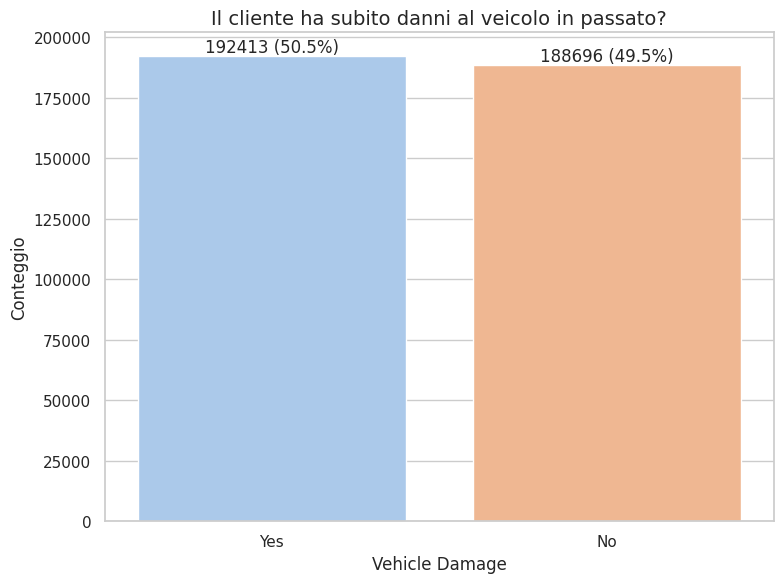

In [36]:
# Set the seaborn theme for a clean look
sns.set(style="whitegrid")

# Create a new figure for the plot with a defined size
plt.figure(figsize=(8, 6))

# Create a countplot to show how many customers have previously had vehicle damage
# Use hue='Vehicle_Damage' to avoid the FutureWarning and apply color palette
ax = sns.countplot(x='Vehicle_Damage', hue='Vehicle_Damage', data=df1, palette='pastel', legend=False)

# Add a descriptive title
plt.title('Il cliente ha subito danni al veicolo in passato?', fontsize=14)

# Calculate the total number of records for percentage annotation
total = len(df1)

# Annotate each bar with count and percentage
for p in ax.patches:
    count = int(p.get_height())               # Get the number of customers per category
    percentage = 100 * count / total          # Calculate its percentage
    ax.annotate(f'{count} ({percentage:.1f}%)',   # Format label with count and percentage
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Place label above each bar
                ha='center', va='bottom', fontsize=12)  # Text alignment and size

# Label axes
plt.xlabel('Vehicle Damage')
plt.ylabel('Conteggio')

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

La variabile *Vehicle_Damage* è ben bilanciata tra le due classi e la rende idonea all'utilizzo nel modello predittivo.

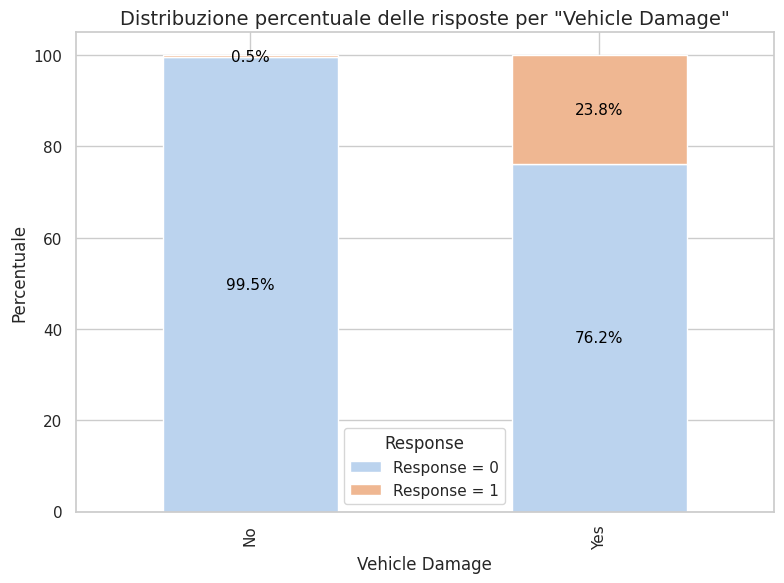

In [37]:
# Imposta lo stile Seaborn
sns.set(style="whitegrid")

# Calcola la tabella di contingenza normalizzata (percentuali)
contingency_damage = df1.groupby('Vehicle_Damage')['Response'].value_counts(normalize=True).unstack().fillna(0) * 100
contingency_damage = contingency_damage.round(1)
contingency_damage.columns = ['Response = 0', 'Response = 1']

# Crea il grafico a barre impilate
ax = contingency_damage.plot(kind='bar',
                             stacked=True,
                             color=['#BBD3EE', '#EFB792'],
                             figsize=(8, 6))

# Aggiungi annotazioni di percentuale su ogni barra
for i, (index, row) in enumerate(contingency_damage.iterrows()):
    y_offset = 0
    for j, value in enumerate(row):
        ax.annotate(f'{value:.1f}%',
                    (i, y_offset + value / 2),
                    ha='center', va='center', fontsize=11, color='black')
        y_offset += value

# Imposta titolo e assi
plt.title('Distribuzione percentuale delle risposte per "Vehicle Damage"', fontsize=14)
plt.xlabel('Vehicle Damage')
plt.ylabel('Percentuale')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

In [38]:
# Crea la tabella di contingenza
contingency_table = pd.crosstab(df1['Vehicle_Damage'], df1['Response'])

# Esegui il test del chi-quadro
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Mostra i risultati
print("Chi-squared statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", f"{p_value:.6f}", '(valore approssimato)')

Chi-squared statistic: 47864.76180117493
Degrees of freedom: 1
P-value: 0.000000 (valore approssimato)


La variabile *Vehicle_Damage* in relazione a *Response* evidenzia un alto tasso di risposta tra i clienti che hanno già subito un danno al veicolo in passatto, rispetto ad una risposta quasi nulla di chi non ha mai subito danni.

### ANALISI DELLA VARIABILE *ANNUAL_PREMIUM*

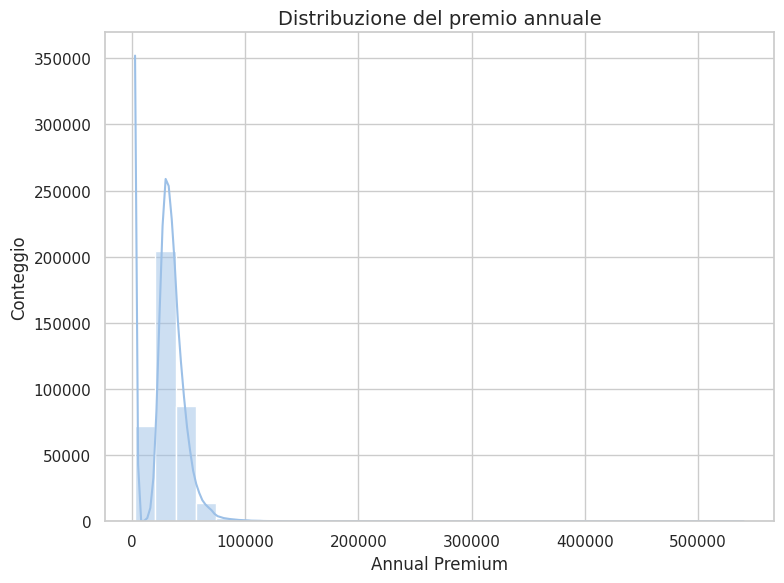

In [39]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(8, 6))

# Plot histogram with KDE for Annual_Premium
ax = sns.histplot(df1['Annual_Premium'],
                  bins=30,
                  kde=True,
                  color='#9cc0e7')

# Add title and labels
plt.title('Distribuzione del premio annuale', fontsize=14)
plt.xlabel('Annual Premium')
plt.ylabel('Conteggio')

# Layout adjustment
plt.tight_layout()
plt.show()

Si nota che la distribuzione e fortemente assimmetrica verso valori più bassi di *Annual Premium*

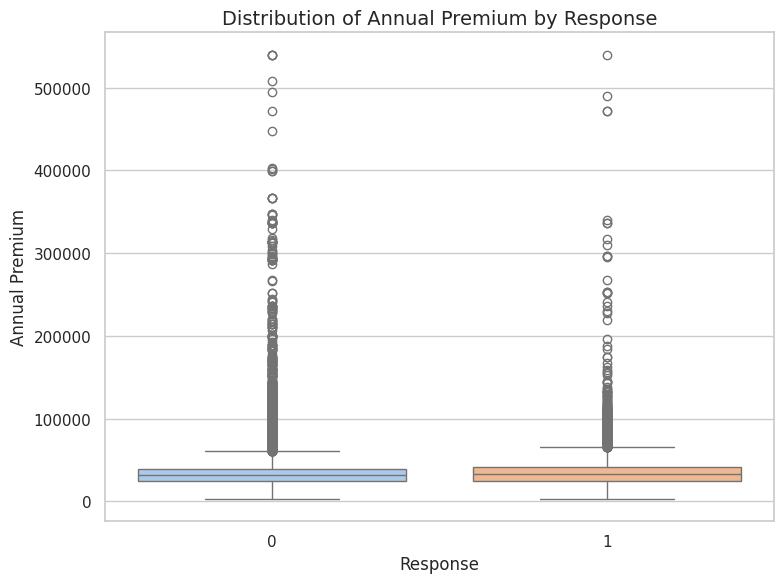

In [40]:
# Set Seaborn visual style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(8, 6))

# Create boxplot of Annual_Premium by Response
ax = sns.boxplot(x='Response',
                 y='Annual_Premium',
                 hue='Response',
                 data=df1,
                 palette='pastel',
                 legend=False)

# Set title and axis labels
plt.title('Distribution of Annual Premium by Response', fontsize=14)
plt.xlabel('Response')
plt.ylabel('Annual Premium')

# Improve layout to avoid label cutoff
plt.tight_layout()
plt.show()

La variabile *Annual_Premium* presente una forte assismetria con molti outliner estremi verso i valori più alti del premio. La mediana è significativamente più bassa della media suggerendo che la maggior parte dei valori su concentra nella fascia più bassa.

### ANALISI DELLA VARIABILE *POLICY_SALES_CHANNEL*

In [41]:
df1['Policy_Sales_Channel'] = df1['Policy_Sales_Channel'].astype(int)

# Calcola frequenze assolute e percentuali
channel_freq = df1['Policy_Sales_Channel'].value_counts()
channel_perc = (channel_freq / len(df) * 100).round(5)

# Crea il DataFrame
channel_summary = pd.DataFrame({
    'Policy_Sales_Channel': channel_freq.index,
    'Count': channel_freq.values,
    'Percentage': channel_perc.values
})

# Ordina per frequenza discendente
channel_summary = channel_summary.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Mostra la tabella
with pd.option_context('display.max_rows', None):
    display(channel_summary)

,Policy_Sales_Channel,Count,Percentage
0,152,134784,35.36626
1,26,79700,20.91265
2,124,73995,19.41571
3,160,21779,5.71464
4,156,10661,2.79736
5,122,9930,2.60555
6,157,6684,1.75383
7,154,5993,1.57252
8,151,3885,1.01939
9,163,2893,0.75910


In [42]:
# Calculate the average acceptance rate (Response = 1) for each sales channel
channel_response_rate = df1.groupby('Policy_Sales_Channel')['Response'].mean()

# Define a function to classify channels based on their acceptance rate
def classify_channel(rate):
    if rate > 0.20:
        return 'high_acceptance'
    elif rate > 0.10:
        return 'medium_acceptance'
    else:
        return 'low_acceptance'

# Apply the classification function to each channel's average response rate
channel_behavior_map = channel_response_rate.apply(classify_channel)

# Map the classification back to the original dataframe
df1['channel_behavior'] = df1['Policy_Sales_Channel'].map(channel_behavior_map)

<Figure size 800x600 with 0 Axes>

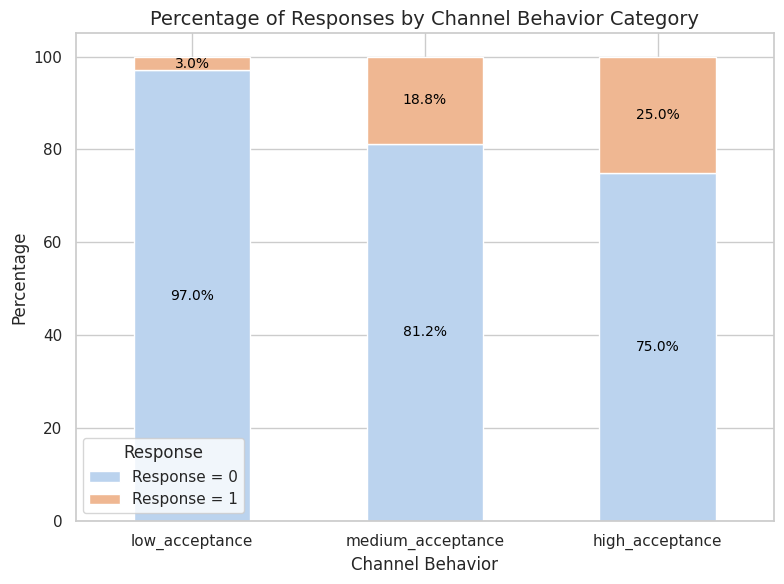

In [43]:
# Create a percentage contingency table for channel_behavior vs Response
contingency_channel_behavior = df1.groupby('channel_behavior')['Response'].value_counts(normalize=True).unstack().fillna(0) * 100
contingency_channel_behavior = contingency_channel_behavior.round(1)
contingency_channel_behavior.columns = ['Response = 0', 'Response = 1']

# Reorder the behavior categories logically
contingency_channel_behavior = contingency_channel_behavior.loc[
    ['low_acceptance', 'medium_acceptance', 'high_acceptance']
]

# Set Seaborn visual style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Plot stacked bar chart
ax = contingency_channel_behavior.plot(kind='bar', stacked=True,
                                       color=['#BBD3EE', '#EFB792'], figsize=(8, 6))

# Annotate each bar segment with its percentage
for i, (index, row) in enumerate(contingency_channel_behavior.iterrows()):
    y_offset = 0
    for value in row:
        ax.annotate(f'{value:.1f}%',
                    (i, y_offset + value / 2),
                    ha='center', va='center', fontsize=10, color='black')
        y_offset += value

# Customize plot titles and axes
plt.title('Percentage of Responses by Channel Behavior Category', fontsize=14)
plt.xlabel('Channel Behavior')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Response')
plt.tight_layout()
plt.show()

### ANALISI DELLA VARIABILE *VINTAGE*

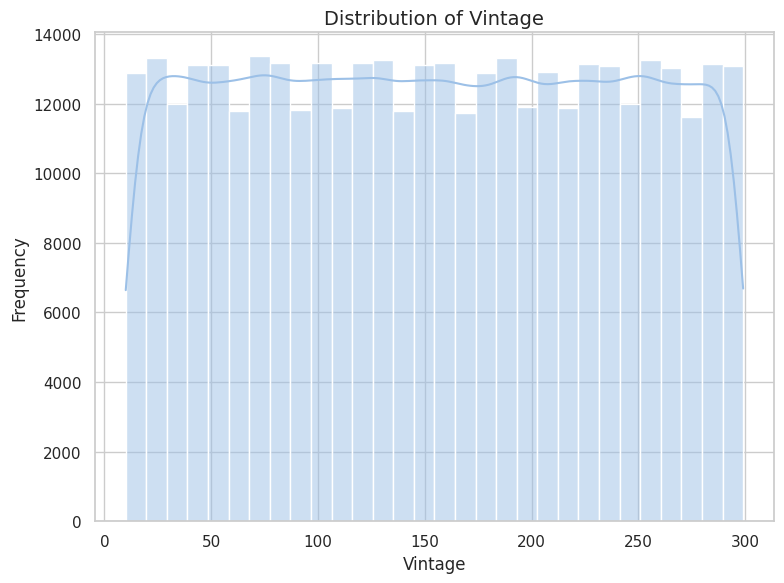

In [44]:
# Set Seaborn visual style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(8, 6))

# Plot histogram with KDE (Kernel Density Estimate) for the 'Vintage' variable
# This shows both frequency and smoothed density
ax = sns.histplot(df1['Vintage'],
                  bins=30,
                  kde=True,
                  color='#9cc0e7')  # Light green tone

# Set plot title and axis labels
plt.title('Distribution of Vintage', fontsize=14)
plt.xlabel('Vintage')
plt.ylabel('Frequency')

# Final layout adjustments
plt.tight_layout()
plt.show()

La variabile Vintage presenta una distribuzione quasi uniforme, senza asimmetrie o valori estremi.

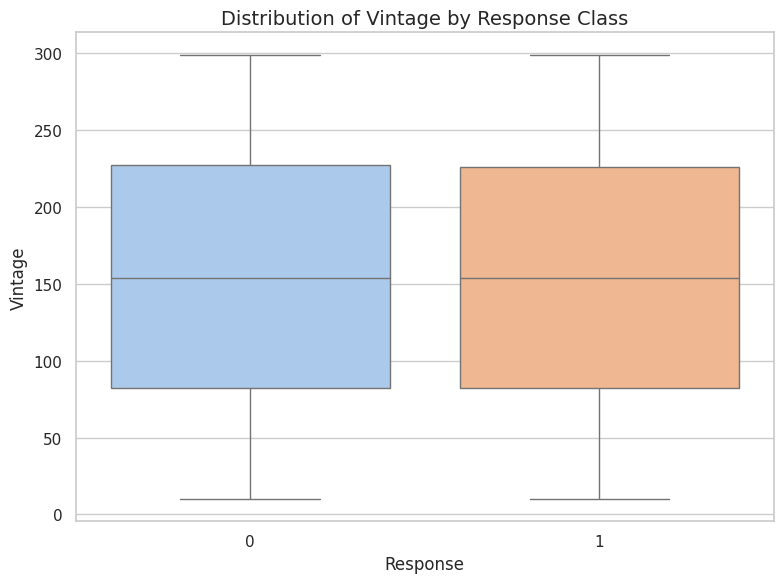

In [45]:
# Set Seaborn visual style
sns.set(style="whitegrid")

# Create a new figure
plt.figure(figsize=(8, 6))

# Create a boxplot to compare the distribution of Vintage for each Response class
ax = sns.boxplot(x='Response', y='Vintage', hue='Response',
                 data=df1, palette='pastel', legend=False)

# Set title and labels
plt.title('Distribution of Vintage by Response Class', fontsize=14)
plt.xlabel('Response')
plt.ylabel('Vintage')

# Layout adjustment
plt.tight_layout()
plt.show()

Il confronto tra i gruppi di risposta mostra che Vintage ha una distribuzione simile sia per chi accetta che per chi rifiuta l’offerta assicurativa. La variabile, quindi, non appare discriminante da sola, ma potrebbe avere un ruolo secondario all’interno di modelli più complessi.

### ANALISI DELLE CORRELAZIONI LINEARI TRA VARIABILI NUMERICHE

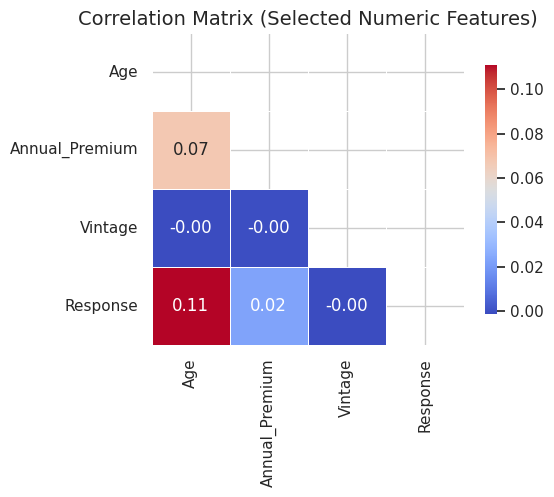

In [46]:
# Select the specific columns
cols = ['Age', 'Annual_Premium', 'Vintage', 'Response']
subset_corr = df1[cols].corr()

# Create a mask to display only the lower triangle
mask = np.triu(np.ones_like(subset_corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.set(style="whitegrid")

ax = sns.heatmap(subset_corr,
                 mask=mask,
                 annot=True,
                 fmt='.2f',
                 cmap='coolwarm',
                 square=True,
                 linewidths=0.5,
                 cbar_kws={"shrink": .8})

# Final layout
plt.title('Correlation Matrix (Selected Numeric Features)', fontsize=14)
plt.tight_layout()
plt.show()

La matrice di correlazione mostra che tra le variabili numeriche selezionate, solo Age presenta una debole correlazione positiva con Response. Le altre, come Annual_Premium e Vintage, non evidenziano relazioni lineari dirette, ma potrebbero comunque fornire valore predittivo in modelli non lineari o attraverso trasformazioni.

### ANALISI DELLE CORRELAZIONI MONOTONE TRA VARIABILI NUMERICHE

La matrice di Spearman consente di esplorare relazioni monotone tra variabili numeriche, anche in presenza di asimmetrie o distribuzioni non lineari. È particolarmente utile per evidenziare pattern che la correlazione di Pearson potrebbe non rilevare.

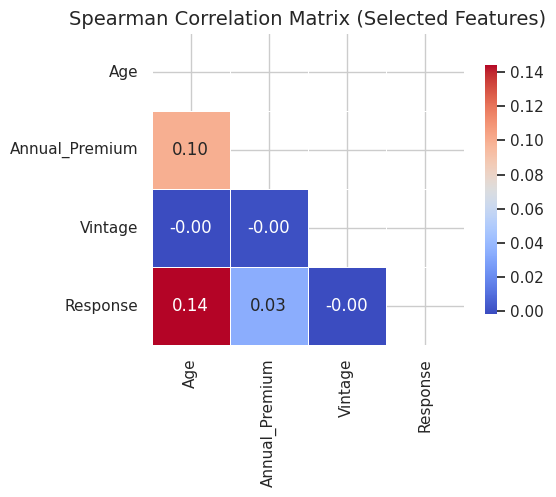

In [47]:
# Select the relevant numeric columns
selected_cols = ['Age', 'Annual_Premium', 'Vintage', 'Response']
numeric_subset = df1[selected_cols]

# Compute the Spearman correlation matrix
spearman_corr = numeric_subset.corr(method='spearman')

# Step 3: Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.set(style="whitegrid")
sns.heatmap(spearman_corr,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

# Title and layout
plt.title('Spearman Correlation Matrix (Selected Features)', fontsize=14)
plt.tight_layout()
plt.show()

La matrice di correlazione di Spearman evidenzia la presenza di una debole relazione monotona positiva tra l’età (Age) e la probabilità di risposta positiva (Response). Le altre variabili numeriche (Annual_Premium, Vintage) non mostrano correlazioni significative con Response, suggerendo che potrebbero essere informative solo se combinate ad altre feature o opportunamente trasformate.

### CONCLUSIONI SULL'ANALISI DEL DATASET

L’analisi preliminare ha consentito di identificare le variabili potenzialmente rilevanti in relazione alla variabile target (Response), attraverso test di significatività e visualizzazioni esplorative. Queste informazioni guideranno la fase successiva di selezione delle feature da includere nei modelli predittivi.

| Variabile              | Usare nel Modello | Come gestirla                                                                 | Modelli consigliati e motivazione                                                                 |
|------------------------|-------------------|-------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| `id`                   | ❌ No              | Identificatore univoco, va escluso                                            | Nessuno – non contiene informazioni predittive                                                    |
| `Gender`               | ✅ Sì              | Variabile categorica; considerare codifica se necessario                      | Regressione Logistica, Random Forest – semplice da codificare e interpretare                      |
| `Age`                  | ✅ Sì              | Numerica continua; possibile binning o normalizzazione                        | Regressione Lineare, SVM – utile per modelli sensibili alla scala delle variabili                 |
| `Driving_License`      | ❌ No              | Sempre uguale per la quasi totalità del dataset, non informativa                          | Nessuno – variabile costante, non aggiunge valore                                                 |
| `Region_Code`          | ✅ Sì              | Troppe classi, da raggruppare o sintetizzare                                  | Gradient Boosting, CatBoost – gestiscono bene variabili categoriche ad alta cardinalità           |
| `Previously_Insured`   | ✅ Sì              | Categorica binaria, chiara separazione                                        | Regressione Logistica, Random Forest – forte potere predittivo                                    |
| `Vehicle_Age`          | ✅ Sì              | Categorica ordinata, utile anche come ordinal encoding                        | Regressione Logistica Ordinale, XGBoost – sfrutta l'ordine intrinseco delle categorie             |
| `Vehicle_Damage`       | ✅ Sì              | Binaria, molto predittiva, va mantenuta                                       | Regressione Logistica, Random Forest – semplice e altamente informativa                           |
| `Annual_Premium`       | ✅ Sì              | Distribuzione asimmetrica, da trasformare (log)                               | Regressione Lineare, SVM – la trasformazione migliora la linearità e la normalità dei residui     |
| `Policy_Sales_Channel` | ✅ Sì              | Troppe categorie; da raggruppare o codificare in base al comportamento        | CatBoost, LightGBM – ottimizzati per gestire variabili categoriche complesse                      |
| `Vintage`              | ✅ Sì              | Distribuzione uniforme, può essere usata direttamente                         | Regressione Lineare, Random Forest – utile per modelli che beneficiano di variabili temporali     |                    |
| `Age_bin`              | ✅ Sì (opzionale)      | Derivata da Age; testare vs variabile continua         | Nessuno – utile solo per esplorazione e visualizzazione                                           |
| `response_behavior`    | ✅ Sì              | Derivata da Region_Code, da usare come categorica                       | Regressione Logistica, Random Forest – semplifica la complessità delle categorie originali        |
| `channel_behavior`     | ✅ Sì              | Derivata da Policy_Sales_Channel come sinstesi dell'informazione                  | Gradient Boosting, CatBoost – mantiene l'informazione predittiva riducendo la dimensionalità      |
| `Response`             | 🎯 Target          | Variabile target per la classificazione (da bilanciare)                                      | &nbsp;         

## PRE-PROCESSING DEI DATI

In [48]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_bin,response_behavior,channel_behavior
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1,40-49,above_avg,medium_acceptance
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0,70-79,neutral,medium_acceptance
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1,40-49,above_avg,medium_acceptance
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0,20-29,neutral,low_acceptance
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0,20-29,neutral,low_acceptance


In [49]:
# Clone dataset before pre processing
df2 = df1.copy()

Ho creato variabili derivate (response_behavior, channel_behavior, Age_bin) raggruppando le originali in 3 classi significative basate sulla correlazione con la risposta (Response). Questo approccio semplifica la dimensionalità del dataset, conserva l’informazione predittiva e migliora la stabilità dei modelli evitando overfitting causato da variabili ad alta cardinalità.

Utilizzero due metodi per verificare se queste varibili derivate sono più o meno rilevanti rispetto alle variabili originali nel determinare la variabile target.

&nbsp;

**Mutual Information (MI)**

La Mutual Information misura la dipendenza tra una variabile predittiva e la variabile target. Valori più alti indicano una maggiore quantità di informazione condivisa tra le due variabili, suggerendo una maggiore rilevanza della variabile predittiva nel determinare la target.

Utilizzare la MI consente di identificare le variabili che forniscono il maggior contributo informativo alla previsione della variabile target, rendendola uno strumento efficace per la selezione delle caratteristiche.

Fonte: [Scikit-Learn Doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html?utm_source=chatgpt.com)

&nbsp;

**Random Forest Feature Importance**

I modelli Random Forest offrono una stima dell’importanza delle variabili basata sulla riduzione dell’impurità (ad esempio, l’indice di Gini) che ciascuna variabile fornisce durante la costruzione degli alberi decisionali. Questa metrica riflette quanto ogni variabile contribuisce alla precisione complessiva del modello.

Questa metodologia è particolarmente utile perché considera le interazioni tra le variabili e la loro capacità di migliorare la previsione della target, offrendo una visione pratica dell’utilità di ciascuna variabile nel contesto del modello.

Fonte: [Geeksforgeeks.org](https://www.geeksforgeeks.org/feature-importance-with-random-forests/?utm_source=chatgpt.com)

&nbsp;

**CONCLUSIONE**

Combinando la Mutual Information e la Random Forest Feature Importance, si ottiene una valutazione completa delle variabili:
	•	Mutual Information: fornisce una misura teorica della dipendenza tra variabili, utile per identificare le caratteristiche più informative.
	•	Random Forest Feature Importance: offre una valutazione pratica dell’impatto di ciascuna variabile sulla performance del modello.

L’utilizzo congiunto di questi metodi permette una selezione delle variabili più robusta e motivata, migliorando l’accuratezza e l’efficienza dei modelli di machine learning.

In [50]:
# Encoding base (solo per Mutual Info e RF, no trasformazioni complesse)
le = LabelEncoder()
df2["Region_Code_encoded"] = le.fit_transform(df2["Region_Code"])
df2["response_behavior_encoded"] = le.fit_transform(df2["response_behavior"])

# Variabile target
y = df2["Response"]

# MUTUAL INFORMATION
from sklearn.model_selection import train_test_split
X_mi = df2[["Region_Code_encoded", "response_behavior_encoded"]]
mi_scores = mutual_info_classif(X_mi, y, discrete_features=True)

print("Mutual Information scores:")
for col, score in zip(X_mi.columns, mi_scores):
    print(f"{col}: {score:.4f}")

# RANDOM FOREST FEATURE IMPORTANCE
X_rf = X_mi.copy()
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
print("\n Random Forest Feature Importances:")
for col, imp in zip(X_rf.columns, importances):
    print(f"{col}: {imp:.4f}")

Mutual Information scores:
Region_Code_encoded: 0.0094
response_behavior_encoded: 0.0082

 Random Forest Feature Importances:
Region_Code_encoded: 0.3889
response_behavior_encoded: 0.6111


in MUT INF Le due variabili hanno un livello simile di informazione rispetto alla variabile target Response.
Anche se Region_Code ha un valore leggermente più alto, la differenza è trascurabile.

 In un modello Random Forest, response_behavior_encoded risulta più importante della variabile originale, indicando che la sintesi in 3 classi ha aumentato l’efficacia predittiva.

 *Abbiamo confrontato la variabile Region_Code con la sua derivata response_behavior, creata per sintetizzare l’informazione in 3 classi. Dai test statistici e da un modello preliminare Random Forest, response_behavior mostra un’importanza predittiva superiore rispetto alla variabile originaria, pur mantenendo una mutual information simile. Pertanto, per motivi di semplicità, interpretabilità ed efficacia, si è deciso di mantenere solo response_behavior nel modello finale.*

In [51]:
# Label Encoding
le_channel = LabelEncoder()
df2["Policy_Sales_Channel_encoded"] = le_channel.fit_transform(df2["Policy_Sales_Channel"])
df2["channel_behavior_encoded"] = le_channel.fit_transform(df2["channel_behavior"])

# Target
y = df2["Response"]

# 📊 MUTUAL INFORMATION
X_mi = df2[["Policy_Sales_Channel_encoded", "channel_behavior_encoded"]]
mi_scores = mutual_info_classif(X_mi, y, discrete_features=True)

print("🔍 Mutual Information scores:")
for col, score in zip(X_mi.columns, mi_scores):
    print(f"{col}: {score:.4f}")

# 🌲 RANDOM FOREST FEATURE IMPORTANCE
X_rf = X_mi.copy()
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
print("\n🌲 Random Forest Feature Importances:")
for col, imp in zip(X_rf.columns, importances):
    print(f"{col}: {imp:.4f}")

🔍 Mutual Information scores:
Policy_Sales_Channel_encoded: 0.0392
channel_behavior_encoded: 0.0375

🌲 Random Forest Feature Importances:
Policy_Sales_Channel_encoded: 0.4285
channel_behavior_encoded: 0.5715


in MUT INF I valori sono quasi identici, quindi la variabile derivata conserva bene l’informazione predittiva dell’originale.

 Il modello Random Forest considera channel_behavior_encoded più importante, quindi è più utile a fini predittivi.

 *Abbiamo confrontato Policy_Sales_Channel con la variabile derivata channel_behavior, creata per sintetizzare i canali in 3 classi più significative. Il test di mutual information mostra una quasi completa equivalenza tra le due variabili in termini di informazione predittiva, mentre un modello Random Forest preliminare assegna maggiore importanza alla variabile derivata. Per questi motivi, si è deciso di utilizzare solo channel_behavior, semplificando il dataset e mantenendo il potere predittivo.*

In [52]:
# Label encoding su Age_bin
df2["Age_bin_encoded"] = LabelEncoder().fit_transform(df2["Age_bin"])

# Mutual Info
X_mi = df2[["Age", "Age_bin_encoded"]]
mi_scores = mutual_info_classif(X_mi, df2["Response"], discrete_features=[False, True])

print("🔍 Mutual Information:")
for col, score in zip(X_mi.columns, mi_scores):
    print(f"{col}: {score:.4f}")

🔍 Mutual Information:
Age: 0.0312
Age_bin_encoded: 0.0283


In [53]:
X_rf = df2[["Age", "Age_bin_encoded"]]
y = df2["Response"]
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
print("\n🌲 Random Forest Feature Importances:")
for col, imp in zip(X_rf.columns, importances):
    print(f"{col}: {imp:.4f}")


🌲 Random Forest Feature Importances:
Age: 0.5216
Age_bin_encoded: 0.4784


La variabile continua Age fornisce leggermente più informazione rispetto alla binning, ma la differenza è modesta.

Il modello Random Forest apprezza entrambe, con un leggero vantaggio per la variabile continua.
Ma la binarizzazione non perde molta efficacia, quindi resta una buona semplificazione.

Nel modello predittivo destinato all’ottimizzazione delle campagne marketing, abbiamo deciso di mantenere Age come variabile numerica continua, in quanto fornisce maggiore potere predittivo rispetto alla sua versione binning Age_bin. Questo consente una segmentazione più fine e un targeting più preciso dei clienti potenzialmente interessati al cross-selling.



In [54]:
# Variabili selezionate
keep_cols = [
    'Gender', 'Age', 'Previously_Insured',
    'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
    'Vintage', 'response_behavior',
    'channel_behavior', 'Response'
]
df2 = df2[keep_cols].copy()

# Codifica binarie e categoriche non ordinate (Label Encoding semplice)
label_cols = ['Gender', 'Vehicle_Damage']
for col in label_cols:
    df2[col] = LabelEncoder().fit_transform(df2[col])

# Ordinal encoding per channel_behavior (low -> medium -> high)
channel_mapping = {'low_acceptance': 0, 'medium_acceptance': 1, 'high_acceptance': 2}
df2['channel_behavior'] = df2['channel_behavior'].map(channel_mapping)

# Ordinal encoding per response_behavior (below_avg -> neutral -> above_avg)
response_mapping = {'below_avg': 0, 'neutral': 1, 'above_avg': 2}
df2['response_behavior'] = df2['response_behavior'].map(response_mapping)

# Ordinal encoding per Vehicle_Age
vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
df2['Vehicle_Age'] = df2['Vehicle_Age'].map(vehicle_age_mapping)

# Trasformazione log per Annual_Premium
df2['Annual_Premium'] = np.log1p(df2['Annual_Premium'])

# ⚖️tandardizzazione per variabili continue
scaler = StandardScaler()
df2[['Age', 'Vintage']] = scaler.fit_transform(df2[['Age', 'Vintage']])

In [55]:
df2.shape

(381109, 10)

In [56]:
df2.head()

,Gender,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,response_behavior,channel_behavior,Response
0,1,0.333777,0,2,1,10.607946,0.748795,2,1,1
1,1,2.396751,0,1,0,10.420405,0.342443,1,1,0
2,1,0.527181,0,2,1,10.553075,-1.521998,2,1,1
3,1,-1.148985,1,0,0,10.261861,0.581474,1,0,0
4,0,-0.633242,1,0,0,10.221832,-1.378580,1,0,0


## GESTIONE DELLO SBILANCIAMENTO DELLE CLASSI


In [57]:
X = df2.drop("Response", axis=1)
y = df2["Response"]

In [58]:
# Cross-validation e metriche
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'precision': make_scorer(precision_score,),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

### Logistic Regression con class_weight=balanced

In [59]:
lr_weighted = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', n_jobs=-1)
scores_weighted = cross_validate(lr_weighted, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)

print("Logistic Regression + class_weight='balanced'")
print("---------------------------------------------")
for metric, value in scores_weighted.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(value):.4f}")

Logistic Regression + class_weight='balanced'
---------------------------------------------
precision: 0.2584
recall: 0.9587
f1: 0.4071
roc_auc: 0.7872


### Logistic Regression con SMOTE

In [60]:
pipeline_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear', n_jobs=-1))
])
scores_smote = cross_validate(pipeline_smote, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)

print("Logistic Regression + SMOTE")
print("---------------------------")
for metric, value in scores_smote.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(value):.4f}")

Logistic Regression + SMOTE
---------------------------
precision: 0.2578
recall: 0.9596
f1: 0.4064
roc_auc: 0.7868


### Logistic Regression con Undersampling

In [61]:
pipeline_under = ImbPipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear', n_jobs=-1))
])
scores_under = cross_validate(pipeline_under, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)

print("Logistic Regression + Undersampling")
print("-----------------------------------")
for metric, value in scores_under.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(value):.4f}")

Logistic Regression + Undersampling
-----------------------------------
precision: 0.2577
recall: 0.9608
f1: 0.4064
roc_auc: 0.7871


### Comparazione risultati per Logistic Regression

In [62]:
comparison = pd.DataFrame({
    "Technique": ["class_weight", "SMOTE", "undersampling"],
    "Precision": [np.mean(scores_weighted['test_precision']),
                  np.mean(scores_smote['test_precision']),
                  np.mean(scores_under['test_precision'])],
    "Recall": [np.mean(scores_weighted['test_recall']),
               np.mean(scores_smote['test_recall']),
               np.mean(scores_under['test_recall'])],
    "F1": [np.mean(scores_weighted['test_f1']),
           np.mean(scores_smote['test_f1']),
           np.mean(scores_under['test_f1'])],
    "ROC_AUC": [np.mean(scores_weighted['test_roc_auc']),
                np.mean(scores_smote['test_roc_auc']),
                np.mean(scores_under['test_roc_auc'])]
})

In [63]:
comparison

,Technique,Precision,Recall,F1,ROC_AUC
0,class_weight,0.258421,0.958660,0.407102,0.787193
1,SMOTE,0.257792,0.959623,0.406407,0.786849
2,undersampling,0.257666,0.960779,0.406354,0.787065


Per Logistic Regression *class_weight* ha ottenuto un F1 leggermente migliore degli altri due metodi, ha anche un ROC-AUC più alto e richiede preprocessing meno complessi rispetto agli altri due metodi.

### RandomForest con class_weight=balanced

In [65]:
# RandomForest con class_weight bilanciato
rf_weighted = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
scores_rf_weighted = cross_validate(rf_weighted, X, y, scoring=scoring, cv=cv, n_jobs=1, return_train_score=False)

print("Random Forest + class_weight='balanced'")
print("---------------------------------------")
for metric, value in scores_rf_weighted.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(value):.4f}")

Random Forest + class_weight='balanced'
---------------------------------------
precision: 0.3277
recall: 0.1500
f1: 0.2058
roc_auc: 0.5535


### RandomForest + SMOTE

In [67]:
# Pipeline: SMOTE + RandomForest
pipeline_rf_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Cross-validation
scores_rf_smote = cross_validate(pipeline_rf_smote, X, y, scoring=scoring, cv=cv, n_jobs=1, return_train_score=False)

print("Random Forest + SMOTE")
print("---------------------")
for metric, value in scores_rf_smote.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(value):.4f}")

Random Forest + SMOTE
---------------------
precision: 0.3092
recall: 0.4274
f1: 0.3588
roc_auc: 0.6470


### RandomForest + Undersampling

In [68]:
# Pipeline: Undersampling + RandomForest
pipeline_rf_under = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Cross-validation
scores_rf_under = cross_validate(pipeline_rf_under, X, y, scoring=scoring, cv=cv, n_jobs=1, return_train_score=False)

print("Random Forest + Undersampling")
print("-----------------------------")
for metric, value in scores_rf_under.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(value):.4f}")

Random Forest + Undersampling
-----------------------------
precision: 0.2779
recall: 0.8470
f1: 0.4185
roc_auc: 0.7698


### Comparazione risultati per RandomForest

In [69]:
comparison_rf = pd.DataFrame({
    "Technique": ["class_weight", "SMOTE", "undersampling"],
    "Precision": [np.mean(scores_rf_weighted['test_precision']),
                  np.mean(scores_rf_smote['test_precision']),
                  np.mean(scores_rf_under['test_precision'])],
    "Recall": [np.mean(scores_rf_weighted['test_recall']),
               np.mean(scores_rf_smote['test_recall']),
               np.mean(scores_rf_under['test_recall'])],
    "F1": [np.mean(scores_rf_weighted['test_f1']),
           np.mean(scores_rf_smote['test_f1']),
           np.mean(scores_rf_under['test_f1'])],
    "ROC_AUC": [np.mean(scores_rf_weighted['test_roc_auc']),
                np.mean(scores_rf_smote['test_roc_auc']),
                np.mean(scores_rf_under['test_roc_auc'])]
})

In [70]:
comparison_rf

,Technique,Precision,Recall,F1,ROC_AUC
0,class_weight,0.327663,0.149968,0.205758,0.553489
1,SMOTE,0.309236,0.427403,0.358833,0.647021
2,undersampling,0.277879,0.847013,0.418470,0.769774


1. class_weight
	•	🔻 Molto basso recall (15%): il modello perde l’85% dei clienti interessati → non è accettabile per il business.
	•	🟥 ROC-AUC molto bassa (0.55) → il modello non distingue bene tra classi.
	•	✅ Precision leggermente più alta, ma non compensa il resto.

2. SMOTE
	•	📈 Recall sale (42%) e ROC-AUC migliora → il modello inizia a distinguere.
	•	⚖️ Compromesso tra precision e recall: utile se vuoi equilibrio.
	•	👎 F1 e ROC-AUC ancora sotto soglia di eccellenza.

3. Undersampling
	•	✅ Recall ottimo (84.7%) → non perdi quasi nessun cliente interessato.
	•	📉 Precision più bassa (27.8%) → alcuni falsi positivi, ma accettabili se il costo della promozione è basso.
	•	🏆 Miglior F1-score e ROC-AUC: modello più efficace globalmente.

⸻

✅ Conclusione operativa

Il miglior bilanciamento per Random Forest nel tuo caso è:
✅ RandomUnderSampler

Perché:
	•	Recuperi la quasi totalità dei clienti potenzialmente interessati al cross-sell (Recall altissimo)
	•	Hai la migliore combinazione tra precision, recall e discriminazione (ROC-AUC)
	•	Performance robuste anche senza complicazioni o sovraccarichi di RAM

### Confronto Logistic Regression e Random Forest
Con LR hai recall vicino al 96% con ottima capacità discriminativa (ROC-AUC ~0.787)

✅ Scelta Strategica:

Per la tua esigenza, Logistic Regression con una qualsiasi tecnica di bilanciamento (anche class_weight="balanced") è la scelta migliore.

	•	🔥 Recall > 95% = intercetti quasi tutti i clienti propensi
	•	📊 ROC-AUC > 0.78 = il modello distingue bene sì/no
	•	🧘‍♂️ Modello semplice, interpretabile, leggero da deployare